## Problem definition

Analyse how airline passagers of 6 US airlines expressed their satisfaction on the airlines' services on Twitter, i.e. whether the passengers' sentiments were positive, negative or neutral. 


In [1]:
!pip install numpy
!pip install pandas 
!pip install sklearn
!pip install matplotlib
!pip install textblob
!pip install git+https://github.com/pymc-learn/pymc-learn


  Cloning https://github.com/pymc-learn/pymc-learn to /tmp/pip-req-build-9igpzx70
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-learn/pymc-learn /tmp/pip-req-build-9igpzx70
  Resolved https://github.com/pymc-learn/pymc-learn to commit 4f1ee680f0e71dd14e0308552b66b14fb18f82af
  Preparing metadata (setup.py) ... done


## Import the necessary packages

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 1000

import re
from textblob import TextBlob
from nltk.tokenize.toktok import ToktokTokenizer
import string
import nltk
from nltk.corpus import stopwords

import seaborn as sn

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

#import os
#os.environ['MKL_THREADING_LAYER'] = 'GNU'
#os.environ['THEANO_FLAGS'] = 'device=cpu'
#import pymc3 as pm
#import seaborn as sns

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

## Load the data set as a dataframe


In [3]:
df_data = pd.read_csv('Tweets.csv')
df_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df_data.shape

(14640, 15)

## Checking missing values in the data set

In [5]:
count = df_data.isnull().sum().sort_values(ascending=False)
percentage_missing_values = ((df_data.isnull().sum()/len(df_data) * 100)).sort_values(ascending=False)
missing_values = pd.concat([count, percentage_missing_values], axis=1, keys=['Count','Percentage'])
missing_values

,Count,Percentage
negativereason_gold,14608,99.781421
airline_sentiment_gold,14600,99.726776
tweet_coord,13621,93.039617
negativereason,5462,37.308743
user_timezone,4820,32.923497
tweet_location,4733,32.329235
negativereason_confidence,4118,28.128415
tweet_id,0,0.000000
airline_sentiment,0,0.000000
airline_sentiment_confidence,0,0.000000


# Data Exploration

1. Evaluate the number of tweets for each airline and plot the counts as a pie chart

   We see that most of the tweets are for "United" airline and least number of tweets are for "Virgin America"

<AxesSubplot:ylabel='airline'>

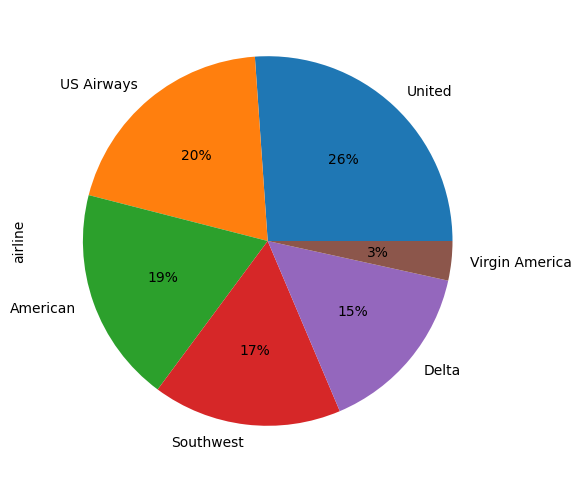

In [6]:
fig = plt.figure(figsize =(8, 6))
df_data.airline.value_counts().plot(kind='pie',autopct='%1.0f%%')

2. Plot the sentiments to see how they are distributed in the dataset 

   Here we see that most of the sentiments are negative, i.e. 63% of the sentiments are negative while 16% and 21% are positive and neutral respectively 
   
  

<AxesSubplot:ylabel='airline_sentiment'>

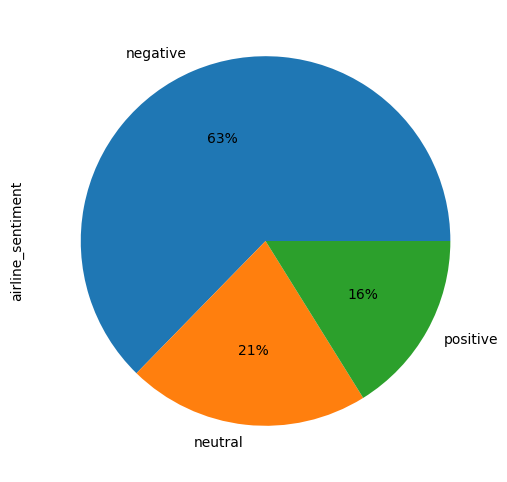

In [7]:
fig = plt.figure(figsize =(8, 6))
df_data.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

3. Plot the sentiments per airline
   
   Here for all the airlines except "Virgin America" the negative sentiment is highest

<AxesSubplot:xlabel='airline'>

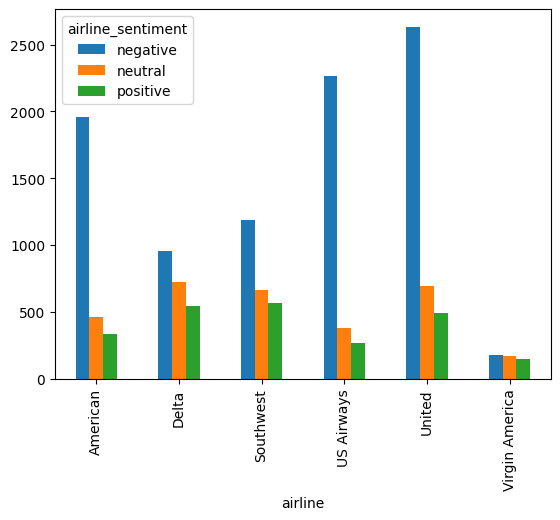

In [8]:
sentiment_per_airline = df_data.groupby(['airline','airline_sentiment']).airline_sentiment.count().unstack()
sentiment_per_airline.plot(kind='bar')

4. Lastly we can also plot the 'Airline sentiment confidence'

   Here we see that the airline sentiment confidence is higher for the negative sentiments and lowest for the neutral sentiments

<AxesSubplot:xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

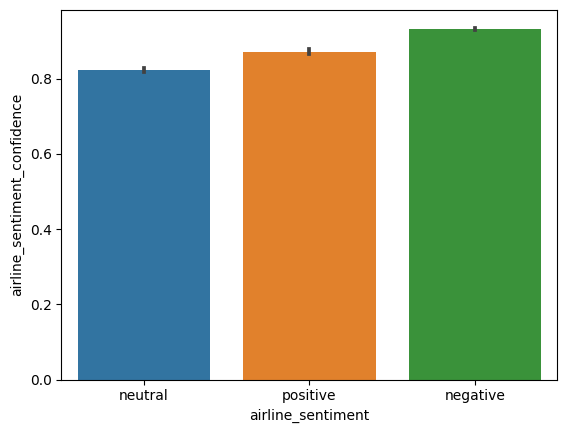

In [9]:
sn.barplot(x='airline_sentiment',y='airline_sentiment_confidence', data=df_data)


### Preprocessing of text data (airline tweets)
Here we clean the tweets removing, punctuations, stop words. special characters, numbers,html and url patterns



In [10]:
#remove punctuation
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text=text.replace(punctuation,'')
    return text

#apply the function to the function to the features
df_data['text'] = df_data['text'].apply(remove_punctuation)


In [11]:
#remove stopwords
stop_words_list = nltk.corpus.stopwords.words('english')

tokenizer = ToktokTokenizer()

#function to remove the stop words
def remove_stopwords(text,is_lower_case=True):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words_list]
    filtered_text = ' '.join(filtered_tokens)
    filtered_text.lower()
    return filtered_text

#apply the function to the features
df_data['text'] = df_data['text'].apply(remove_stopwords)


In [12]:
#remove special characters
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z0-9\s]', '',text)
    return text
 #apply the function
df_data['text'] = df_data['text'].apply(remove_special_characters)

In [13]:
#remove numbers
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

#Apply the function
df_data['text'] = df_data['text'].apply(remove_numbers)
#df_data.head(5)


In [14]:
#remove html patterns
def remove_html_patterns(text):
    html_patterns = re.compile('<.*?>')
    return html_patterns.sub(r' ',text)

#Apply the function
df_data['text'] = df_data['text'].apply(remove_html_patterns)

In [15]:
#remove url patterns
def remove_url_patterns(text):
    url_patterns = re.compile(r'https?://\S+|www\.\S+')
    return url_patterns.sub(r' ',text)

#Apply the function
df_data['text'] = df_data['text'].apply(remove_url_patterns)

In [16]:
df_data['text'][20]

'VirginAmerica first fares May three times carriers seats available select'

### Modelling
The features are the tweets (text column) while the label is the airline sentiment

We use the TfidVectorizer from the ScikitLearn library to convert text features into TF-IDF feature vectors i.e. to convert the text into a format that can be used by the model

Dividing the data set into training and testing set

In [17]:
features = df_data['text'].values
labels = df_data['airline_sentiment'].values

#print(features)
#print(labels)

In [18]:
vector = TfidfVectorizer()
vector.fit(features)
features = vector.transform(features)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

### 1. RandomForestClassifier

In [20]:
text_classifier = RandomForestClassifier()
text_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
predictions = text_classifier.predict(X_test)

In [22]:
print(confusion_matrix(y_test,predictions))

print('model train score', text_classifier.score(X_train, y_train))
print('model test score', text_classifier.score(X_test, y_test))
print('accuracy score', accuracy_score(y_test, predictions))

[[1758   85   27]
 [ 332  252   30]
 [ 165   60  219]]
model train score 0.9964993169398907
model test score 0.7612704918032787
accuracy score 0.7612704918032787


#### Classification report and confusion matrix

              precision    recall  f1-score   support

    negative       0.78      0.94      0.85      1870
     neutral       0.63      0.41      0.50       614
    positive       0.79      0.49      0.61       444

    accuracy                           0.76      2928
   macro avg       0.74      0.61      0.65      2928
weighted avg       0.75      0.76      0.74      2928



<AxesSubplot:>

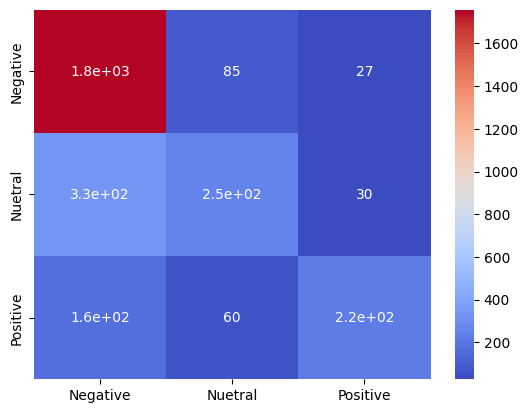

In [23]:
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test,predictions)
sn.heatmap(cm,annot=True, cmap='coolwarm', xticklabels=['Negative', 'Nuetral','Positive'], yticklabels=['Negative', 'Nuetral','Positive'])

### 2. DecisionTreeClassifier

In [24]:
#import the algorith for training the model
from sklearn.tree import DecisionTreeClassifier

#instantiate the model
tree =  DecisionTreeClassifier()

#fit the train set to the model
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [25]:
#predict the testing data
tree_predictions = tree.predict(X_test)
tree_predictions

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [26]:
#Check the test,train and accuracy score of the model 
print('The DecisionTreeClassifier model test score is', tree.score(X_test,y_test))
print('The DecisionTreeClassifier model train score is', tree.score(X_train,y_train))
print('The DecisionTreeClassifier model accuracy score is', accuracy_score(y_test,tree_predictions))

The DecisionTreeClassifier model test score is 0.6868169398907104
The DecisionTreeClassifier model train score is 0.9964993169398907
The DecisionTreeClassifier model accuracy score is 0.6868169398907104


### Classification report and confusion matrix

Classification report               precision    recall  f1-score   support

    negative       0.79      0.80      0.79      1870
     neutral       0.45      0.46      0.45       614
    positive       0.59      0.53      0.56       444

    accuracy                           0.69      2928
   macro avg       0.61      0.60      0.60      2928
weighted avg       0.69      0.69      0.69      2928



<AxesSubplot:>

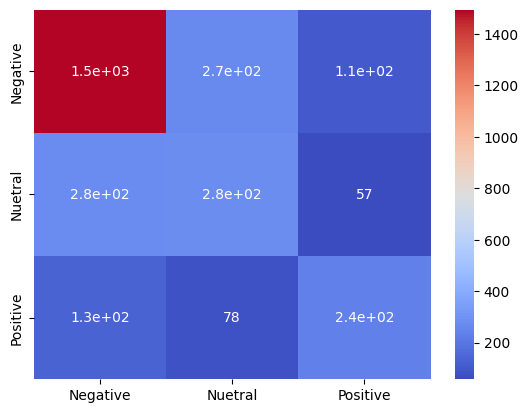

In [27]:
print('Classification report', classification_report(y_test,tree_predictions))
#confusion_matrix
cm = confusion_matrix(y_test,tree_predictions)
sn.heatmap(cm,annot=True, cmap='coolwarm', xticklabels=['Negative', 'Nuetral','Positive'], yticklabels=['Negative', 'Nuetral','Positive'])

### 3.  MultinomialNB

In [28]:
#import the algorith for training the model
from sklearn.naive_bayes import MultinomialNB

#instantiate the model
multinomial = MultinomialNB()

#fit the train set to the model
multinomial.fit(X_train,y_train)

MultinomialNB()

In [29]:
#predict the testing data
multinomial_predictions = tree.predict(X_test)
multinomial_predictions

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [30]:
#Check the test,train and accuracy score of the model 
print('The MultinomialNB model test score is', multinomial.score(X_test,y_test))
print('The MultinomialNB model train score is', multinomial.score(X_train,y_train))
print('The MultinomialNB model accuracy score is', accuracy_score(y_test,multinomial_predictions))


The MultinomialNB model test score is 0.6861338797814208
The MultinomialNB model train score is 0.7246413934426229
The MultinomialNB model accuracy score is 0.6868169398907104


### Classification report and confusion matrix

Classification report               precision    recall  f1-score   support

    negative       0.79      0.80      0.79      1870
     neutral       0.45      0.46      0.45       614
    positive       0.59      0.53      0.56       444

    accuracy                           0.69      2928
   macro avg       0.61      0.60      0.60      2928
weighted avg       0.69      0.69      0.69      2928



<AxesSubplot:>

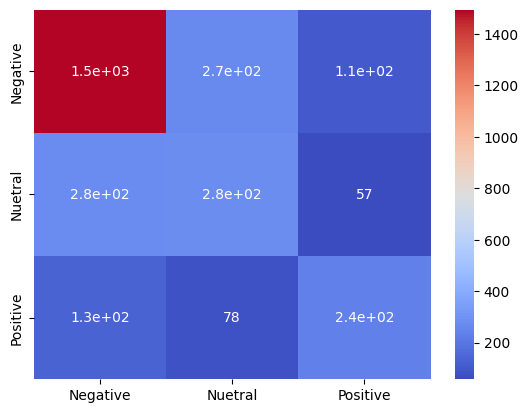

In [31]:
print('Classification report', classification_report(y_test,multinomial_predictions))

#confusion_matrix
cm = confusion_matrix(y_test,multinomial_predictions)
sn.heatmap(cm,annot=True, cmap='coolwarm', xticklabels=['Negative', 'Nuetral','Positive'], yticklabels=['Negative', 'Nuetral','Positive'])

### Testing the models on new data

In [32]:
text = "love service take flight next time"
text = [text]
text_int = vector.transform(text)
prediction = tree.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  positive


In [33]:
text = "love service take flight next time"
text = [text]
text_int = vector.transform(text)
prediction = text_classifier.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


In [34]:
text = "love service take flight next time"
text = [text]
text_int = vector.transform(text)
prediction = multinomial.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


In [35]:
text = "worst airline ever flight been schedules leave since pm now smh"
text = [text]
text_int = vector.transform(text)
prediction = tree.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


In [36]:
text = "worst airline ever flight been schedules leave since pm now smh"
text = [text]
text_int = vector.transform(text)
prediction = text_classifier.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


In [37]:
text = "worst airline ever flight been schedules leave since pm now smh"
text = [text]
text_int = vector.transform(text)
prediction = multinomial.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


### Comments

We have an accuracy score of 76% for the RandomForestClassifier while the DecisionTreeClassifier and the mutinomialNB give an accuracy score of 68%

### Attempt to improve the accuracy score of the models
Here we try to downsample the negative and neutral sentiments such that the data is balanced amongst the 3 classes

In [38]:
#Create a DataFrame for each sentiment and Get the shape of each sentiment
positive_sentiments = df_data[df_data["airline_sentiment"] == "positive"]
negative_sentiments = df_data[df_data["airline_sentiment"] == "negative"]
neutral_sentiments  = df_data[df_data["airline_sentiment"] == "neutral"]

print(positive_sentiments.shape)
print(negative_sentiments.shape)
print(neutral_sentiments.shape)


(2363, 15)
(9178, 15)
(3099, 15)


In [39]:
#Downsampling the negative sentiment data

from sklearn.utils import resample
negative_sentiments_downsample = resample(negative_sentiments,
             replace=True,
             n_samples=2400,
             random_state=42)

print(negative_sentiments_downsample.shape)


(2400, 15)


In [40]:
#Downsampling the neutral sentiment data

neutral_sentiments_downsample = resample(neutral_sentiments,
             replace=True,
             n_samples=2400,
             random_state=42)

print(neutral_sentiments_downsample.shape)

(2400, 15)


negative    2400
neutral     2400
positive    2363
Name: airline_sentiment, dtype: int64


<AxesSubplot:ylabel='airline_sentiment'>

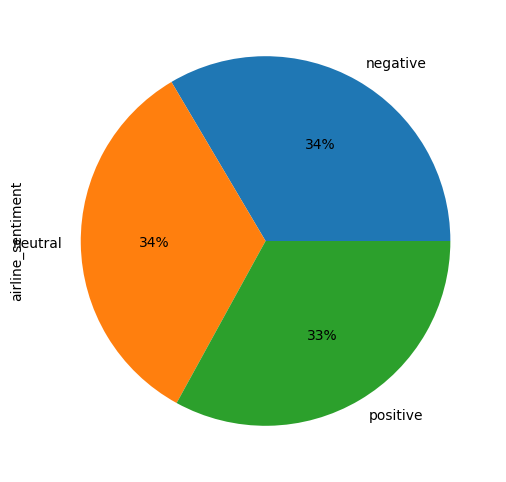

In [41]:
#Creating the new Dataframe with the downsampled sentiments
#Plotting a pie chat to show the balanced data distribution

data_downsampled = pd.concat([negative_sentiments_downsample,positive_sentiments,neutral_sentiments_downsample])
print(data_downsampled["airline_sentiment"].value_counts())

fig = plt.figure(figsize =(8, 6))
data_downsampled.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')


In [42]:
#Dividing the new data into features and labels

new_features = data_downsampled['text'].values
new_labels = data_downsampled['airline_sentiment'].values

#print(new_features)
#print(new_labels)

In [43]:
#Vectorizing the features

vector.fit(new_features)
new_features = vector.transform(new_features)

In [44]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_features, new_labels, test_size=0.2, random_state=0)

In [45]:
text_classifier.fit(X_train_new, y_train_new)

RandomForestClassifier()

In [46]:
new_rand_class_pred = text_classifier.predict(X_test_new)

[[356  83  24]
 [ 66 389  35]
 [ 47  78 355]]
model train score 0.9970331588132635
model test score 0.7676203768318214
accuracy score 0.7676203768318214
Classification report               precision    recall  f1-score   support

    negative       0.76      0.77      0.76       463
     neutral       0.71      0.79      0.75       490
    positive       0.86      0.74      0.79       480

    accuracy                           0.77      1433
   macro avg       0.77      0.77      0.77      1433
weighted avg       0.77      0.77      0.77      1433



<AxesSubplot:>

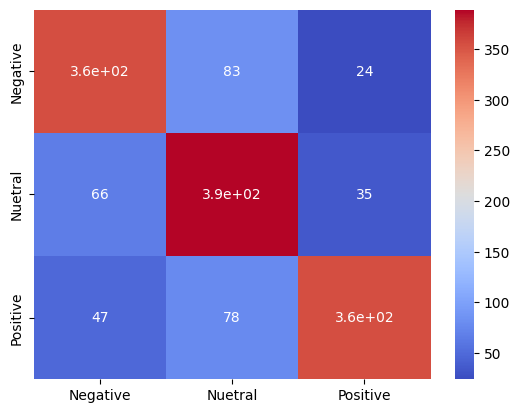

In [47]:
print(confusion_matrix(y_test_new,new_rand_class_pred))

print('model train score', text_classifier.score(X_train_new, y_train_new))
print('model test score', text_classifier.score(X_test_new, y_test_new))
print('accuracy score', accuracy_score(y_test_new, new_rand_class_pred))
print('Classification report', classification_report(y_test_new, new_rand_class_pred))
#confusion_matrix
cm = confusion_matrix(y_test_new, new_rand_class_pred)
sn.heatmap(cm,annot=True, cmap='coolwarm', xticklabels=['Negative', 'Nuetral','Positive'], yticklabels=['Negative', 'Nuetral','Positive'])

In [48]:
tree.fit(X_train_new, y_train_new)

DecisionTreeClassifier()

[[331  79  53]
 [ 75 363  52]
 [ 65  93 322]]
model train score 0.9970331588132635
model test score 0.7090020935101187
accuracy score 0.7090020935101187
Classification report               precision    recall  f1-score   support

    negative       0.70      0.71      0.71       463
     neutral       0.68      0.74      0.71       490
    positive       0.75      0.67      0.71       480

    accuracy                           0.71      1433
   macro avg       0.71      0.71      0.71      1433
weighted avg       0.71      0.71      0.71      1433



<AxesSubplot:>

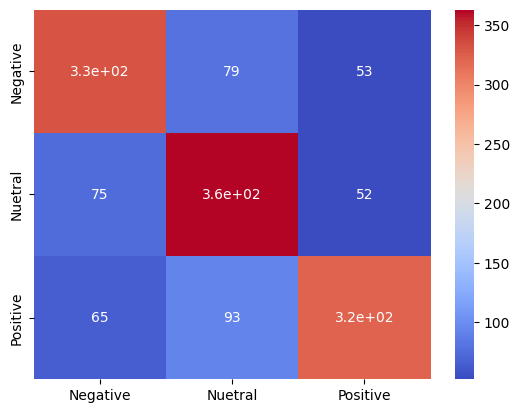

In [49]:
new_tree_pred = tree.predict(X_test_new)
print(confusion_matrix(y_test_new,new_tree_pred))

print('model train score', tree.score(X_train_new, y_train_new))
print('model test score', tree.score(X_test_new, y_test_new))
print('accuracy score', accuracy_score(y_test_new, new_tree_pred))
print('Classification report', classification_report(y_test_new, new_tree_pred))
#confusion_matrix
cm = confusion_matrix(y_test_new, new_tree_pred)
sn.heatmap(cm,annot=True, cmap='coolwarm', xticklabels=['Negative', 'Nuetral','Positive'], yticklabels=['Negative', 'Nuetral','Positive'])

In [50]:
multinomial.fit(X_train_new, y_train_new)

MultinomialNB()

[[405  39  19]
 [105 320  65]
 [ 46  57 377]]
model train score 0.8945898778359511
model test score 0.7690160502442428
accuracy score 0.7690160502442428
Classification report               precision    recall  f1-score   support

    negative       0.73      0.87      0.79       463
     neutral       0.77      0.65      0.71       490
    positive       0.82      0.79      0.80       480

    accuracy                           0.77      1433
   macro avg       0.77      0.77      0.77      1433
weighted avg       0.77      0.77      0.77      1433



<AxesSubplot:>

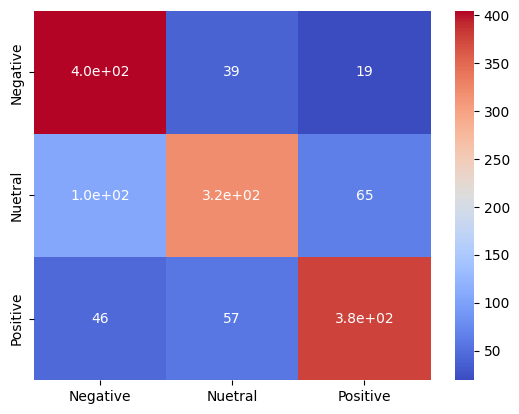

In [51]:
new_multinomial_pred = multinomial.predict(X_test_new)
print(confusion_matrix(y_test_new,new_multinomial_pred))

print('model train score', multinomial.score(X_train_new, y_train_new))
print('model test score', multinomial.score(X_test_new, y_test_new))
print('accuracy score', accuracy_score(y_test_new, new_multinomial_pred))
print('Classification report', classification_report(y_test_new, new_multinomial_pred))
#confusion_matrix
cm = confusion_matrix(y_test_new, new_multinomial_pred)
sn.heatmap(cm,annot=True, cmap='coolwarm', xticklabels=['Negative', 'Nuetral','Positive'], yticklabels=['Negative', 'Nuetral','Positive'])

In [52]:
text = "love service take flight next time"
text = [text]
text_int = vector.transform(text)
prediction = text_classifier.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  positive


In [53]:
text = "love service take flight next time"
text = [text]
text_int = vector.transform(text)
prediction = tree.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  positive


In [54]:
text = "love service take flight next time"
text = [text]
text_int = vector.transform(text)
prediction = multinomial.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  positive


In [55]:
text = "worst airline ever flight been schedules leave since pm now smh"
text = [text]
text_int = vector.transform(text)
prediction = text_classifier.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


In [56]:
text = "worst airline ever flight been schedules leave since pm now smh"
text = [text]
text_int = vector.transform(text)
prediction = tree.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


In [57]:
text = "worst airline ever flight been schedules leave since pm now smh"
text = [text]
text_int = vector.transform(text)
prediction = multinomial.predict(text_int)
print('this airline sentiment is ', prediction[0])

this airline sentiment is  negative


### Conclusion
1. We used the airline sentiments data to predict twitter sentiments

2. We built 3 models, namel, RandomForestClassifier, DecisionTree and multinomialNB

3. The RandomForestClassifier has a better score compared to the other models

4. We also downsampled the negative and neutral sentiments such that the sentiments were distributed equally amongst the three classes

5. We observed that the models' accuracy scores are improved by feeding a balalnced dataset to the models
